In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression


# Prepare data for model

In [2]:
df = pd.read_csv('data\kickstarter_data_with_features.csv',index_col=0)



In [3]:
#These are the only columns we can use as input
df = df[['name', 'goal', 'blurb', 'launched_at', 'deadline','category','state', 'country']]

In [4]:
#filter out all countries not english-speaking
english_countries = ['US', 'IE', 'GB', 'AU', 'CA', 'NZ', ]
df= df[df['country'].isin(english_countries)]

In [5]:
#create 'success'filter which only shows failed or success and cuts out other options
suc_filt = ['failed', 'successful']
df = df[df['state'].isin(suc_filt)]
# Convert fail or succuess to 0 or 1
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})

In [6]:
#Two seperate dataframes are created below, one of only success and one of only fail
faileddf = df[df['state'] == 0]
sucdf = df[df['state'] == 1]

In [7]:
#Baseline prediction
failed = len(faileddf)
suc = len(sucdf)

suc / failed

0.5578593996840442

## Create NLP Pipeline

In [8]:
columns = ['name','blurb', 'state']

to_df = df.copy()

to_df = to_df[columns]

In [9]:
to_df.fillna(' ', inplace=True)

In [10]:
to_df['text']=to_df['name']+' '+to_df['blurb']

# NLP

In [11]:
train, test = train_test_split(to_df, train_size=0.80, test_size=0.20, 
                                stratify= to_df['state'], random_state=3)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                                stratify= train['state'], random_state=3)

In [12]:
features = 'text'
target = 'state'

In [13]:
X_train = train[features]
X_val = val[features]
X_test = test[features]
y_train = train[target]
y_val = val[target]
y_test = test[target]

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import xgboost as xgb
"""
vect = CountVectorizer(stop_words='english', ngram_range=(1,3))

lrm = xgb.XGBClassifier(n_jobs=-1, max_depth=150)
pipe = Pipeline([
                 #Vectorizer
                 ('vect', vect),
                 # Classifier
                 ('clf', lrm)
                ])
pipe.fit(X_train, y_train)
# Predicting with a test dataset
xgpredicted = pipe.predict(X_val)

print("Classifier Accuracy:", accuracy_score(y_val, xgpredicted))
print("Classifier Recall:", recall_score(y_val, xgpredicted))
"""
#joblib.dump(pipe, 'woops.pkl')


'\nvect = CountVectorizer(stop_words=\'english\', ngram_range=(1,3))\n\nlrm = xgb.XGBClassifier(n_jobs=-1, max_depth=150)\npipe = Pipeline([\n                 #Vectorizer\n                 (\'vect\', vect),\n                 # Classifier\n                 (\'clf\', lrm)\n                ])\npipe.fit(X_train, y_train)\n# Predicting with a test dataset\nxgpredicted = pipe.predict(X_val)\n\nprint("Classifier Accuracy:", accuracy_score(y_val, xgpredicted))\nprint("Classifier Recall:", recall_score(y_val, xgpredicted))\n'

In [15]:
"""plot_confusion_matrix(pipe, X_val, y_val, cmap='Greens', values_format=' ')
plt.grid(False)"""

"plot_confusion_matrix(pipe, X_val, y_val, cmap='Greens', values_format=' ')\nplt.grid(False)"

## New pipeline for non text

In [16]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta

In [17]:
df_nt = df[['goal', 'launched_at', 'deadline', 'country', 'state']]

In [18]:
#convert time columns to campaign length
df['deadline'] = df['deadline'].str[:10]
df['launched_at'] = df['launched_at'].str[:10]
df_nt['deadline'] = pd.to_datetime(df_nt['deadline'], format="%Y/%m/%d")
df_nt['launched_at'] = pd.to_datetime(df_nt['launched_at'], format="%Y/%m/%d")

df['deadline'] = pd.to_datetime(df['deadline'], format="%Y/%m/%d")
df['launched_at'] = pd.to_datetime(df['launched_at'], format="%Y/%m/%d")
#create new column
df_nt['cam_length'] = df_nt['deadline'] - df_nt['launched_at']
df['cam_length'] = df['deadline'] - df['launched_at']


In [19]:
#encode categorical columns

lb_make = LabelEncoder()
#df_nt["cam_length"] = lb_make.fit_transform(df_nt["cam_length"])
df["cam_length"] = lb_make.fit_transform(df["cam_length"])

In [20]:
df_nt = df_nt[['goal', 'cam_length', 'state']]

In [21]:
df

,name,goal,blurb,launched_at,deadline,category,state,country,cam_length
0,Auntie Di's Music Time Sign ASL for Hearing an...,1500.0,MTS ASL Curriculum Workbook is a reproducible ...,2014-12-17,2015-01-23,Academic,0,US,36
1,Jump Start Kindergarten Toolkit,500.0,"This kit teaches how to print, correct an ugly...",2015-03-02,2015-05-01,Academic,0,US,59
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,100000.0,"Establishing a free, world-class, public libra...",2015-01-25,2015-03-26,Academic,0,US,59
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",5000.0,Goal: Introducing a new word into the English ...,2014-09-06,2014-10-06,Academic,0,US,29
5,Shadow School Board - Reforming Texas School B...,13000.0,Shadow School Board will provide parents & tax...,2015-10-21,2015-11-20,Academic,0,US,29
...,...,...,...,...,...,...,...,...,...
20625,Private.Center - Private Social Network,20000.0,Private.Center - the Private Social Network is...,2015-12-17,2016-02-15,Apps,0,GB,59
20626,Pathfinder Adventure Card Game Character Track...,5000.0,A companion app for the Pathfinder Adventure C...,2016-05-26,2016-07-01,Apps,0,AU,35
20629,Sloth Face App,10000.0,"We all love fatbooth and Ugly booth, why not s...",2015-02-13,2015-04-14,Apps,0,US,59
20630,DriverTools,2500.0,Production android app for cab drivers and tru...,2015-04-20,2015-05-20,Apps,0,US,29


In [22]:
train2, test2 = train_test_split(df_nt, train_size=0.80, test_size=0.20, 
                                stratify= df_nt['state'], random_state=3)

train2, val2 = train_test_split(train2, train_size=0.80, test_size=0.20, 
                                stratify= train2['state'], random_state=3)


features2 = ['goal', 'cam_length']
target2 = 'state'

X_train2 = train2[features2]
X_val2 = val2[features2]
X_test2 = test2[features2]
y_train2 = train2[target2]
y_val2 = val2[target2]
y_test2 = test2[target2]

In [23]:
df.head()

,name,goal,blurb,launched_at,deadline,category,state,country,cam_length
0,Auntie Di's Music Time Sign ASL for Hearing an...,1500.0,MTS ASL Curriculum Workbook is a reproducible ...,2014-12-17,2015-01-23,Academic,0,US,36
1,Jump Start Kindergarten Toolkit,500.0,"This kit teaches how to print, correct an ugly...",2015-03-02,2015-05-01,Academic,0,US,59
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,100000.0,"Establishing a free, world-class, public libra...",2015-01-25,2015-03-26,Academic,0,US,59
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",5000.0,Goal: Introducing a new word into the English ...,2014-09-06,2014-10-06,Academic,0,US,29
5,Shadow School Board - Reforming Texas School B...,13000.0,Shadow School Board will provide parents & tax...,2015-10-21,2015-11-20,Academic,0,US,29


In [24]:
df = df[['name', 'goal', 'blurb', 'state', 'cam_length']]
NUMERIC_COLUMNS = ['goal', "cam_length", ]
LABELS = ['state']
numeric_data_only = df[NUMERIC_COLUMNS]
NON_LABELS = [c for c in df.columns if c not in LABELS]
TEXT_COLUMNS = [c for c in NON_LABELS if c not in NUMERIC_COLUMNS]

In [25]:
def declare(df):
    NUMERIC_COLUMNS = ['goal', "cam_length", ]
    LABELS = ['state']
    numeric_data_only = df[NUMERIC_COLUMNS]
    NON_LABELS = [c for c in df.columns if c not in LABELS]
    TEXT_COLUMNS = [c for c in NON_LABELS if c not in NUMERIC_COLUMNS]

    return df

In [26]:
declare(df)

,name,goal,blurb,state,cam_length
0,Auntie Di's Music Time Sign ASL for Hearing an...,1500.0,MTS ASL Curriculum Workbook is a reproducible ...,0,36
1,Jump Start Kindergarten Toolkit,500.0,"This kit teaches how to print, correct an ugly...",0,59
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,100000.0,"Establishing a free, world-class, public libra...",0,59
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",5000.0,Goal: Introducing a new word into the English ...,0,29
5,Shadow School Board - Reforming Texas School B...,13000.0,Shadow School Board will provide parents & tax...,0,29
...,...,...,...,...,...
20625,Private.Center - Private Social Network,20000.0,Private.Center - the Private Social Network is...,0,59
20626,Pathfinder Adventure Card Game Character Track...,5000.0,A companion app for the Pathfinder Adventure C...,0,35
20629,Sloth Face App,10000.0,"We all love fatbooth and Ugly booth, why not s...",0,59
20630,DriverTools,2500.0,Production android app for cab drivers and tru...,0,29


In [27]:


def combine_text_columns(data_frame, to_drop=['state', 'goal', 'cam_length']):
    """ Takes the dataset as read in, drops the non-feature, non-text columns and
        then combines all of the text columns into a single vector that has all of
        the text for a row.

        :param data_frame: The data as read in with read_csv (no preprocessing necessary)
        :param to_drop (optional): Removes the numeric and label columns by default.
    """
    # drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)

    # joins all of the text items in a row (axis=1)
    # with a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)


In [28]:
df

,name,goal,blurb,state,cam_length
0,Auntie Di's Music Time Sign ASL for Hearing an...,1500.0,MTS ASL Curriculum Workbook is a reproducible ...,0,36
1,Jump Start Kindergarten Toolkit,500.0,"This kit teaches how to print, correct an ugly...",0,59
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,100000.0,"Establishing a free, world-class, public libra...",0,59
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",5000.0,Goal: Introducing a new word into the English ...,0,29
5,Shadow School Board - Reforming Texas School B...,13000.0,Shadow School Board will provide parents & tax...,0,29
...,...,...,...,...,...
20625,Private.Center - Private Social Network,20000.0,Private.Center - the Private Social Network is...,0,59
20626,Pathfinder Adventure Card Game Character Track...,5000.0,A companion app for the Pathfinder Adventure C...,0,35
20629,Sloth Face App,10000.0,"We all love fatbooth and Ugly booth, why not s...",0,59
20630,DriverTools,2500.0,Production android app for cab drivers and tru...,0,29


In [29]:
combine_text_columns(df)

0        Auntie Di's Music Time Sign ASL for Hearing an...
1        Jump Start Kindergarten Toolkit This kit teach...
2        Ojukwu Balewa Awolowo (O.B.A.) Public Library ...
3        MASTIZE - [mas-TAHYZ, MAS-tahyz]  - to spread ...
5        Shadow School Board - Reforming Texas School B...
                               ...                        
20625    Private.Center - Private Social Network Privat...
20626    Pathfinder Adventure Card Game Character Track...
20629    Sloth Face App We all love fatbooth and Ugly b...
20630    DriverTools Production android app for cab dri...
20631    Let's Trail app We recently launched version 1...
Length: 15778, dtype: object

In [30]:
NUMERIC_COLUMNS + LABELS

['goal', 'cam_length', 'state']

In [31]:
df

,name,goal,blurb,state,cam_length
0,Auntie Di's Music Time Sign ASL for Hearing an...,1500.0,MTS ASL Curriculum Workbook is a reproducible ...,0,36
1,Jump Start Kindergarten Toolkit,500.0,"This kit teaches how to print, correct an ugly...",0,59
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,100000.0,"Establishing a free, world-class, public libra...",0,59
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",5000.0,Goal: Introducing a new word into the English ...,0,29
5,Shadow School Board - Reforming Texas School B...,13000.0,Shadow School Board will provide parents & tax...,0,29
...,...,...,...,...,...
20625,Private.Center - Private Social Network,20000.0,Private.Center - the Private Social Network is...,0,59
20626,Pathfinder Adventure Card Game Character Track...,5000.0,A companion app for the Pathfinder Adventure C...,0,35
20629,Sloth Face App,10000.0,"We all love fatbooth and Ugly booth, why not s...",0,59
20630,DriverTools,2500.0,Production android app for cab drivers and tru...,0,29


In [32]:
# Numeric Pipeline
## define a function that gets only numeric cols
from sklearn.preprocessing import FunctionTransformer
get_numeric_data = FunctionTransformer(lambda x: x[['goal', 'cam_length']], validate=False)
get_declarations = FunctionTransformer(declare, validate=False)
numeric_pipeline = Pipeline([
    ('declarer', get_declarations),
    ('selector', get_numeric_data)
])

# Text Pipeline
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

text_pipeline = Pipeline([
    ('declarer', get_declarations),
    ('selector', get_text_data),
    ('vectorizer', CountVectorizer(stop_words='english', ngram_range=(1,3)))
])


In [33]:
NUMERIC_COLUMNS

['goal', 'cam_length']

In [34]:
from sklearn.pipeline import FeatureUnion
from sklearn.multiclass import OneVsRestClassifier

join_numeric_text_features = FeatureUnion(
    transformer_list= [
        ('numeric_features', numeric_pipeline),
        ('text_features', text_pipeline)
    ] )


In [35]:
df['text'] = combine_text_columns(df)

In [36]:
df = df[['goal', 'state', 'cam_length', 'text']]

In [37]:
# split into train test
dummy_labels = pd.get_dummies(df[LABELS])

X_train, X_test, y_train, y_test = train_test_split(df[['goal', 'cam_length', 'text']], df['state'],train_size=0.80, test_size=0.20, stratify= df['state'], random_state=3)

In [38]:
# Overall pipeline
pl = Pipeline([
    ('union', join_numeric_text_features),
    ('clf', OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=300, random_state=7)))
])


In [39]:
pl.fit(X_train, y_train)
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on dataset: ", accuracy)


Accuracy on dataset:  0.7316223067173637


In [40]:
xgpredicted = pl.predict(X_test)
print("Classifier Accuracy:", accuracy_score(y_test, xgpredicted))
print("Classifier Recall:", recall_score(y_test, xgpredicted))

Classifier Accuracy: 0.7316223067173637
Classifier Recall: 0.5504424778761062


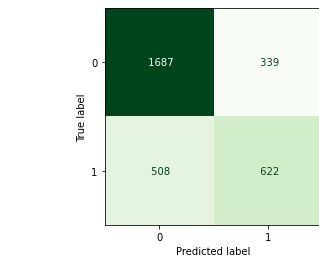

In [41]:
plot_confusion_matrix(pl, X_test, y_test, cmap='Greens', values_format=' ')
plt.grid(False)

In [42]:

pl.predict_proba(X_test)[160] 

array([9.992633e-01, 7.367086e-04], dtype=float32)

In [52]:
import dill
import joblib
import pickle



pickle.dump(pl, open( "multi_modeler.pkl", "wb" ) )
#joblib.dump(pl, 'job_multi_model.pkl')



PicklingError: Can't pickle <function <lambda> at 0x0000015AA8511AE8>: attribute lookup <lambda> on __main__ failed

In [44]:
model = dill.load(open('multi_model.pkl', 'rb'))

In [53]:
model.predict_proba(X_test)

array([[0.08665264, 0.91334736],
       [0.09759986, 0.90240014],
       [0.87766546, 0.12233453],
       ...,
       [0.70963955, 0.29036042],
       [0.99551594, 0.00448406],
       [0.98179746, 0.01820252]], dtype=float32)

In [46]:
X_test

,goal,cam_length,text
12083,6000.0,28,Bot Bash Parties Robot Battle Kits After winni...
2703,1000.0,29,Fandom Hearts 2 - A Fanmade Kingdom Hearts Par...
9700,5000.0,29,Developing Android Live Wallpaper Write a book...
9770,3000.0,29,Taking ToGather mobile App to the NEXT LEVEL T...
14297,60000.0,29,Brewometer: Wireless Hydrometer and Thermomete...
...,...,...,...
1065,800.0,29,"Super Date, The Dating Game Show for Superhero..."
2019,250.0,29,The AOA Presents: The Maiden of Orleans The Ar...
9939,15000.0,82,Open Astronomical Image Processing GUI Astrono...
4988,1000.0,29,JobFinder.Ninja The Freelance website to end a...
